In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split


In [3]:
path = '/content/drive/MyDrive/modelowanie/projekt/combined_data.csv'
df = pd.read_csv(path)

#HER2-neg
df = df[df['characteristics_ch1_4'].astype(str).str.strip().str.endswith("N")].copy()

#data preprocessing
df.drop(columns=['title'], inplace=True)
geo_col = ['geo_accession']
characteristics_cols = [col for col in df.columns if 'characteristics' in col.lower()]
other_cols = [col for col in df.columns if 'characteristics' not in col.lower() and col != 'geo_accession']


#clinical
df_meta = df[geo_col + characteristics_cols]
df_meta.set_index("geo_accession", inplace=True)
df_meta = df_meta.copy()
new_column_names = [str(el).split(':')[0].strip() for el in df_meta.iloc[0, :]]
df_meta.columns = new_column_names

for col in df_meta.columns:
    df_meta[col] = df_meta[col].astype(str).str.split(':').str[-1].str.strip()

#expresion
df_gene_expression = df[geo_col + other_cols]
df_gene_expression.set_index("geo_accession", inplace=True)
df_gene_expression_clean = df_gene_expression.loc[:, ~df_gene_expression.columns.str.startswith("AFFX-")]

df_expr_final = df_gene_expression_clean.T

#final check
common_samples = df_expr_final.columns.intersection(df_meta.index)
df_expr_final = df_expr_final[common_samples]
df_meta_final = df_meta.loc[common_samples]
df_expr_final.index.name = 'gene'

print(f"Expression matrix: {df_expr_final.shape} (gene × samples)")
print(f"Clinical data: {df_meta.shape} (samples × characteristics)")


/tmp/ipython-input-3-3148239008.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Expression matrix: (22215, 485) (gene × samples)
Clinical data: (485, 20) (samples × characteristics)


In [4]:
#weights file
path_weights = "/content/drive/MyDrive/modelowanie/projekt/GSE25066_Genelist_weights.txt"

with open(path_weights, encoding='utf-8') as f:
    content = f.read().split('expression levels.')[1].strip()

df_weights = pd.DataFrame([el.split('\t') for el in content.split('\n')])
df_weights.columns = df_weights.iloc[0, :]
df_weights.drop(0, inplace=True)


print(df_weights.head())

0  probeset_id        weight   ER predictor
1    212531_at   0.031192123  erp      surv
2     40569_at  -0.026466619  erp      surv
3  221681_s_at  -0.021569328  erp      surv
4  211874_s_at  -0.025468777  erp      surv
5  200899_s_at  -0.001733298  erp      surv


In [5]:
df_meta_final["pathologic_response_pcr_rd"].unique()

array(['RD', 'pCR', 'NA', 'RCB-II', 'RCB-III', 'RCB-0/I'], dtype=object)

In [6]:
#ER−
meta = df_meta_final[df_meta_final["er_status_ihc"] == "N"].copy()
y = meta["pathologic_response_pcr_rd"].isin(["pCR", "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

train_idx, val_idx = train_test_split(
    meta.index,
    test_size=0.3,
    stratify=y,
    random_state=42
)

pd.Series(train_idx).to_csv("train_idx_er_neg.csv", index=False, header=False)
pd.Series(val_idx).to_csv("val_idx_er_neg.csv", index=False, header=False)


In [7]:
#ER+
meta = df_meta_final[df_meta_final["er_status_ihc"] == "P"].copy()
y = meta["pathologic_response_pcr_rd"].isin(["pCR","RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

train_idx_er_pos, val_idx_er_pos = train_test_split(
    meta.index,
    test_size=0.3,
    stratify=y,
    random_state=42
)

pd.Series(train_idx_er_pos).to_csv("train_idx_er_pos.csv", index=False, header=False)
pd.Series(val_idx_er_pos).to_csv("val_idx_er_pos.csv", index=False, header=False)


In [16]:
def evaluate_hatzis_linear(er_status_value, df_meta_final, df_expr_final, df_weights, train_idx_file, val_idx_file, y_score_val, verbose=True):

    #ER status
    meta = df_meta_final[df_meta_final["er_status_ihc"] == er_status_value].copy()
    expr = df_expr_final[meta.index].copy().astype(float)

    er_tag = "erp" if er_status_value == "P" else "ern"
    weights_df = df_weights[(df_weights["predictor"] == "rcb01") & (df_weights["ER"] == er_tag)]
    common_probes = expr.index.intersection(weights_df["probeset_id"])
    weights = weights_df.set_index("probeset_id").loc[common_probes, "weight"].astype(float)
    expr = expr.loc[common_probes]

    #score
    score = expr.T.dot(weights)
    meta["rcb01_score"] = score
    meta["response_binary"] = meta["pathologic_response_pcr_rd"].isin(["pCR", "RCB-0", "RCB-I", "RCB-0/I"]).astype(int)

    #validaiton dataset
    train_idx = pd.read_csv(train_idx_file, header=None)[0].values
    val_idx = pd.read_csv(val_idx_file, header=None)[0].values

    meta_train = meta.loc[train_idx]
    meta_val = meta.loc[val_idx]

    y_true = meta_val["response_binary"]
    y_score = meta_val["rcb01_score"]
    y_pred = (y_score > y_score_val).astype(int)

    #metrics
    if y_true.nunique() < 2:
        auc_val = float("nan")
    else:
        auc_val = roc_auc_score(y_true, y_score)

    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv_val = TN / (TN + FN) if (TN + FN) > 0 else 0
    balanced_acc = (rec + specificity) / 2

    if verbose:
        grupa = "ER+" if er_status_value == "P" else "ER−"
        print(f"\nrcb01 in {grupa}")
        print("Confusion matrix:")
        print(cm)
        print(f"AUC:       {auc_val:.2f}")
        print(f"Accuracy:  {acc:.2f}")
        print(f"Sensitivity (Recall):    {rec:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f"PPV (Precision): {prec:.2f}")
        print(f"NPV:       {npv_val:.2f}")
        print(f"Balanced Accuracy: {balanced_acc:.2f}")

    return {
        "group": "ER+" if er_status_value == "P" else "ER−",
        "y_true": y_true,
        "y_score": y_score,
        "AUC": auc_val,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "Specificity": specificity,
        "NPV": npv_val,
        "Balanced_Accuracy": balanced_acc,
        "Confusion_matrix": cm,
        "Predicted_sensitive_share": (y_score > 0).mean(),
        "n_val": len(meta_val),
        "val_responder_share": y_true.mean()
    }


ER- group

In [27]:
results_ern = evaluate_hatzis_linear(
    er_status_value="N",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    df_weights=df_weights,
    train_idx_file="/content/drive/MyDrive/modelowanie/projekt/train_idx_er_neg.csv",
    val_idx_file="/content/drive/MyDrive/modelowanie/projekt/val_idx_er_neg.csv",
    y_score_val = -9
)



rcb01 in ER−
Confusion matrix:
[[32 10]
 [ 3 14]]
AUC:       0.88
Accuracy:  0.78
Sensitivity (Recall):    0.82
Specificity: 0.76
PPV (Precision): 0.58
NPV:       0.91
Balanced Accuracy: 0.79


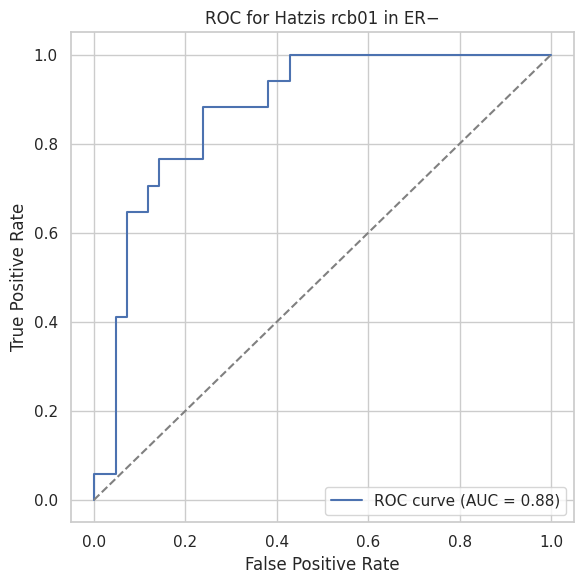

In [28]:
y_true = results_ern["y_true"]
y_score = results_ern["y_score"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Hatzis rcb01 in ER−")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
def rcb01_boxplot(df, score_col="rcb01_score", response_col="response_binary", title=""):

    df_plot = df.copy()
    df_plot["response"] = df_plot[response_col].map({1: "Responder", 0: "Non-responder"})

    group1 = df_plot[df_plot["response"] == "Responder"][score_col]
    group0 = df_plot[df_plot["response"] == "Non-responder"][score_col]

    plt.figure(figsize=(6, 5))
    sns.set(style="whitegrid")
    sns.boxplot(x="response", y=score_col, data=df_plot, palette="Set2")

    plt.title(title)
    plt.xlabel("Response")
    plt.ylabel(score_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-11-3401674347.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="response", y=score_col, data=df_plot, palette="Set2")


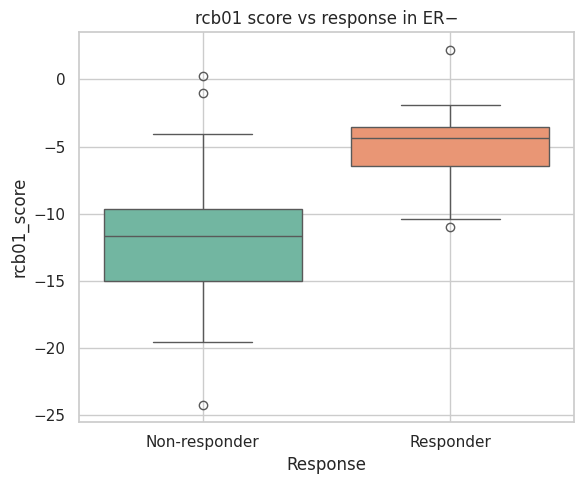

In [29]:
df_val = pd.DataFrame({
    "rcb01_score": results_ern["y_score"],
    "response_binary": results_ern["y_true"]
})

rcb01_boxplot(
    df_val,
    score_col="rcb01_score",
    response_col="response_binary",
    title="rcb01 score vs response in ER−"
)


ER+ group

In [18]:
results_erp = evaluate_hatzis_linear(
    er_status_value="P",
    df_meta_final=df_meta_final,
    df_expr_final=df_expr_final,
    df_weights=df_weights,
    train_idx_file="/content/drive/MyDrive/modelowanie/projekt/train_idx_er_pos.csv",
    val_idx_file="/content/drive/MyDrive/modelowanie/projekt/val_idx_er_pos.csv",
    y_score_val = 118
)



rcb01 in ER+
Confusion matrix:
[[62 15]
 [ 3  7]]
AUC:       0.82
Accuracy:  0.79
Sensitivity (Recall):    0.70
Specificity: 0.81
PPV (Precision): 0.32
NPV:       0.95
Balanced Accuracy: 0.75


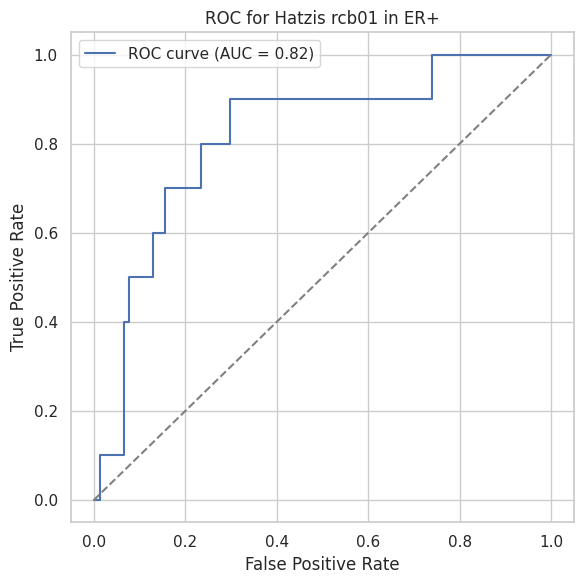

In [14]:
y_true = results_erp["y_true"]
y_score = results_erp["y_score"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Hatzis rcb01 in ER+")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-11-3401674347.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="response", y=score_col, data=df_plot, palette="Set2")


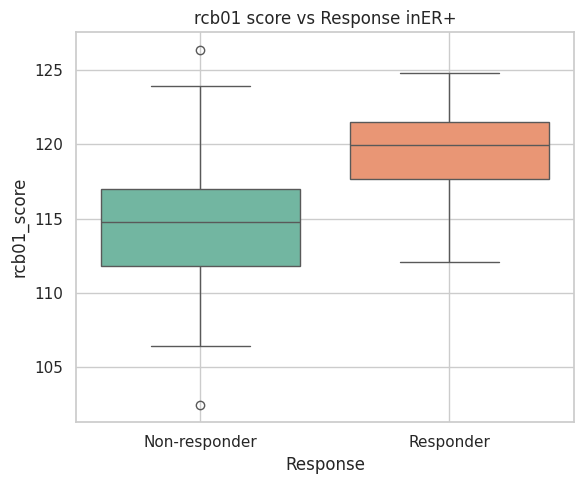

In [15]:
df_val = pd.DataFrame({
    "rcb01_score": results_erp["y_score"],
    "response_binary": results_erp["y_true"]
})

rcb01_boxplot(
    df_val,
    score_col="rcb01_score",
    response_col="response_binary",
    title="rcb01 score vs Response inER+"
)

In [31]:
results_list = [results_ern, results_erp]

metrics_df = pd.DataFrame({
    r["group"]: {
        "AUC": r["AUC"],
        "Accuracy": r["Accuracy"],
        "Precision": r["Precision"],
        "Recall (Sensitivity)": r["Recall"],
        "Specificity": r["Specificity"],
        "NPV": r["NPV"],
        "Balanced Accuracy": r["Balanced_Accuracy"]
    }
    for r in results_list
})

metrics_df


,ER−,ER+
AUC,0.875350,0.815584
Accuracy,0.779661,0.793103
Precision,0.583333,0.318182
Recall (Sensitivity),0.823529,0.700000
Specificity,0.761905,0.805195
NPV,0.914286,0.953846
Balanced Accuracy,0.792717,0.752597


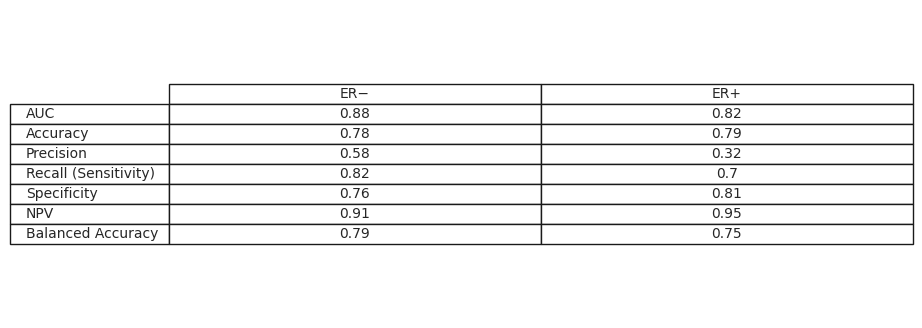

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

table = ax.table(
    cellText=metrics_df.round(2).values,
    rowLabels=metrics_df.index,
    colLabels=metrics_df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.savefig("metrics_table.png", bbox_inches='tight', dpi=300)
